[EM] iter 00: innov_energy=0.2835, rho(A)=0.7201
[EM] iter 05: innov_energy=0.1988, rho(A)=0.7002
[EM] iter 10: innov_energy=0.1914, rho(A)=0.7686
[EM] iter 15: innov_energy=0.1891, rho(A)=0.8142
[EM] iter 20: innov_energy=0.1887, rho(A)=0.8289
[EM] iter 25: innov_energy=0.1883, rho(A)=0.8386
[EM] iter 30: innov_energy=0.1881, rho(A)=0.8443
[EM] iter 35: innov_energy=0.1879, rho(A)=0.8476
[EM] iter 39: innov_energy=0.1878, rho(A)=0.8492

=== Base results ===
rho(A + B Ky_b C) = 0.9347631625720393
rho(A + B Ky_e C) = 0.9347793671343383
True J(pi_e)         : 0.3047
MB (learned sim)     : 0.3164
SN-PDIS estimate     : 0.2318   (ESS≈86.6)
DR (control variate) : 0.3091
[saved] output1/fig_01_logged_data.png


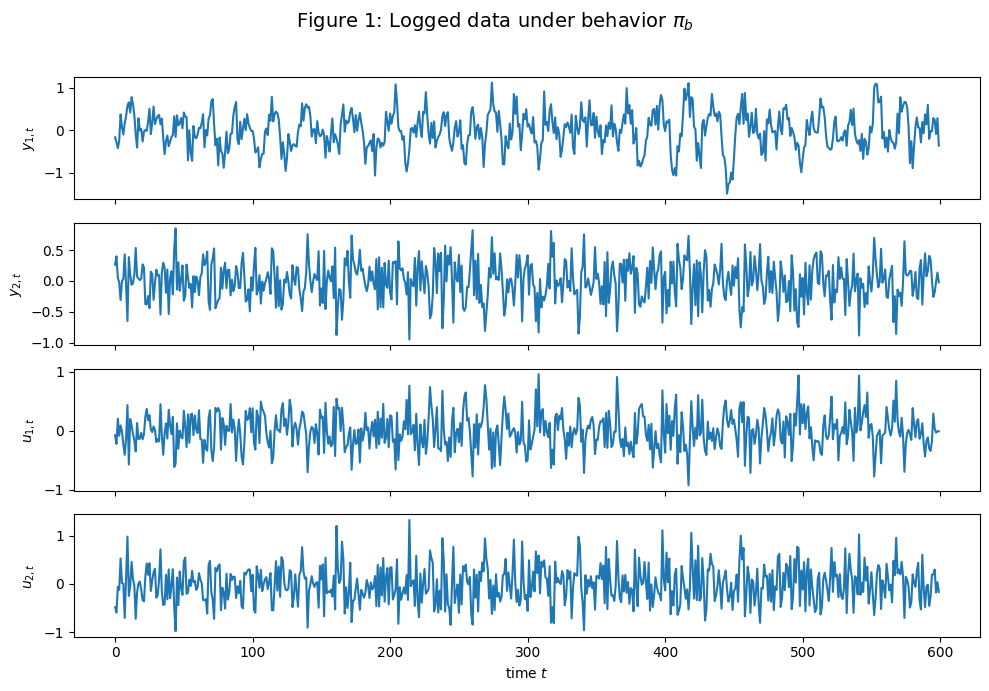

[saved] output1/fig_02_em_convergence.png


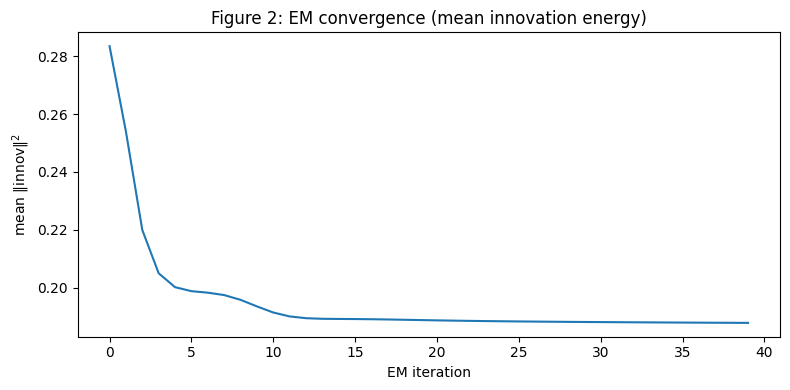

[saved] output1/fig_03_prediction_fit.png


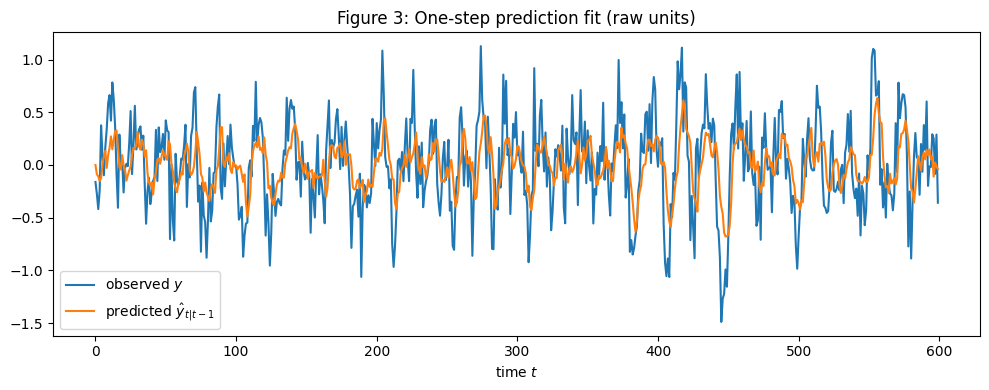

[saved] output1/fig_04_innovation_bands.png


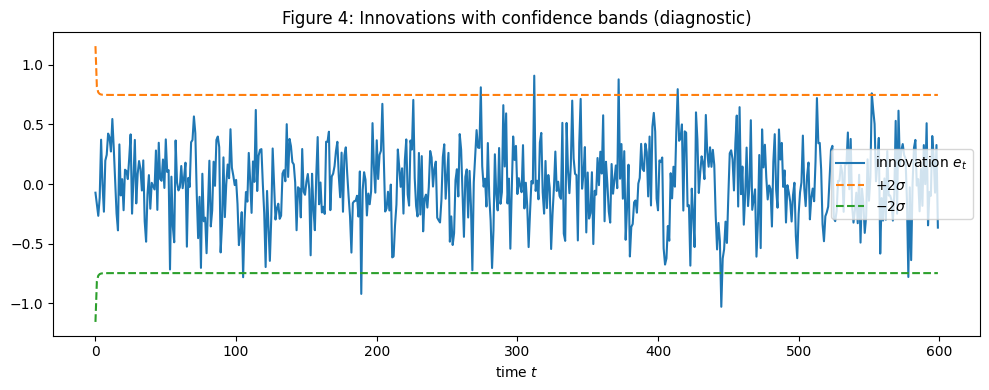

[saved] output1/fig_05_log_weights.png


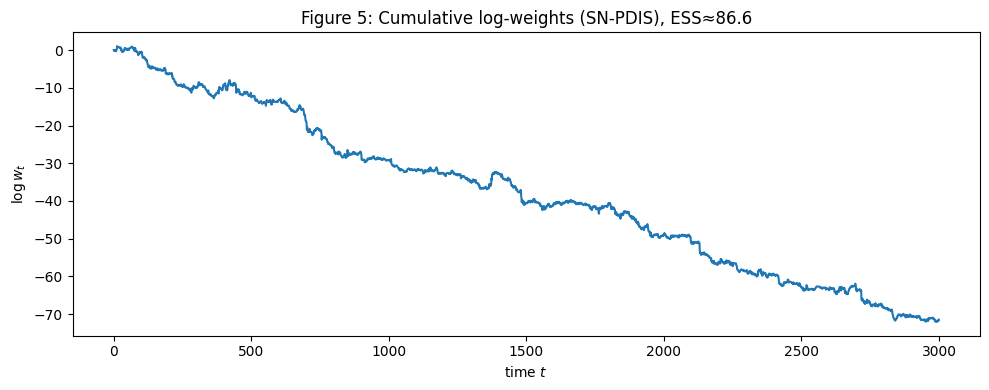

[saved] output1/fig_06_ope_comparison.png


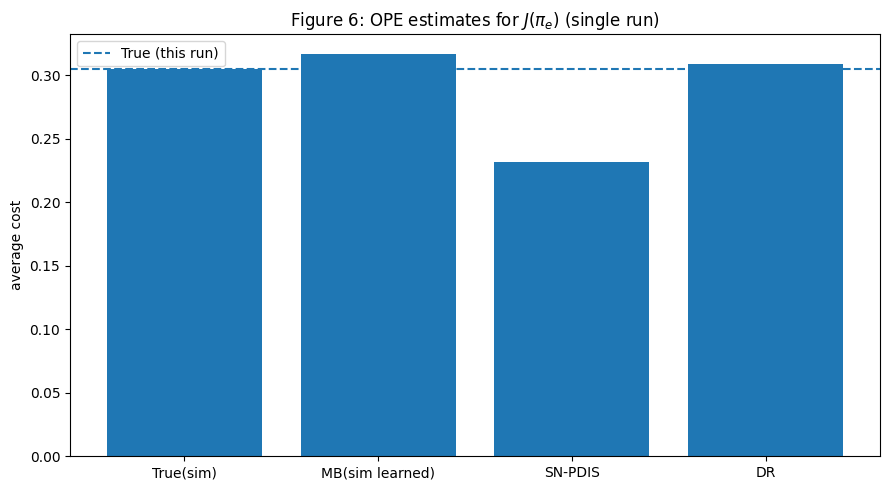

[saved] output1/fig_07_ess_vs_delta.png


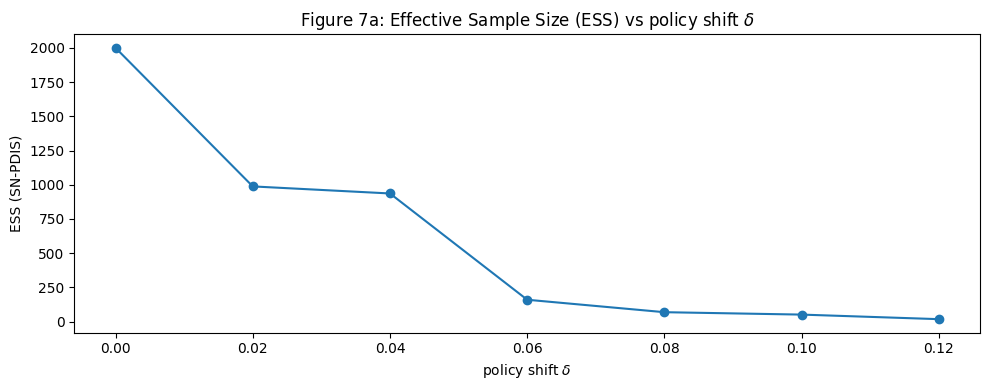

[saved] output1/fig_08_error_vs_delta.png


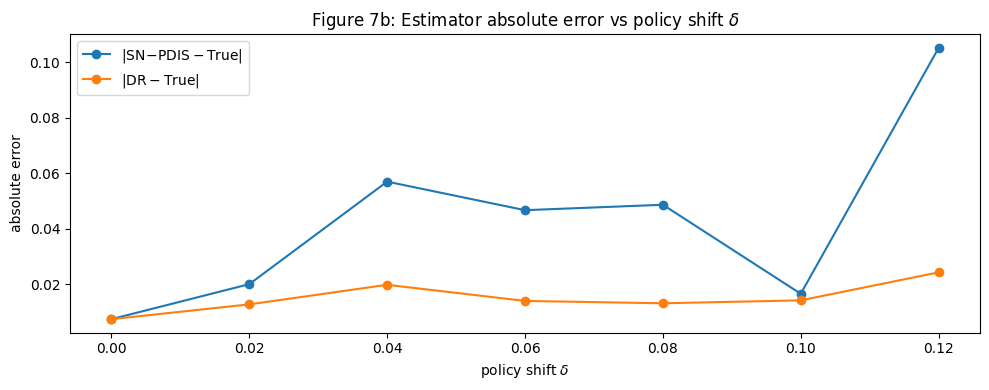

[saved] output1/fig_09_instantaneous_cost.png


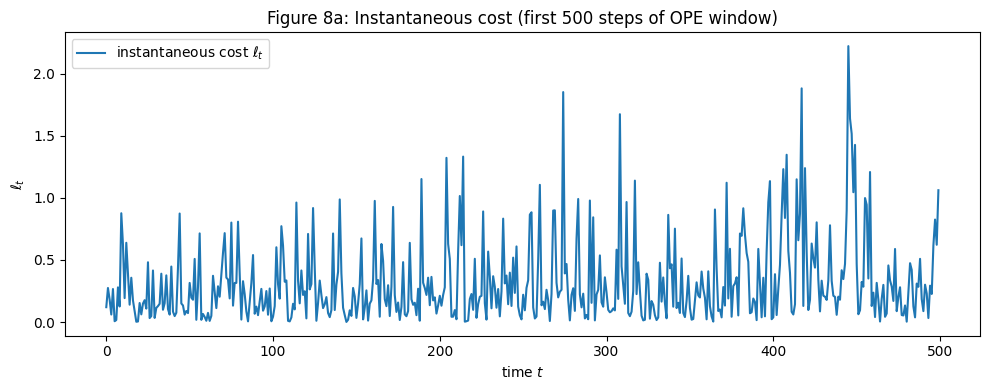

[saved] output1/fig_10_weighted_contribution.png


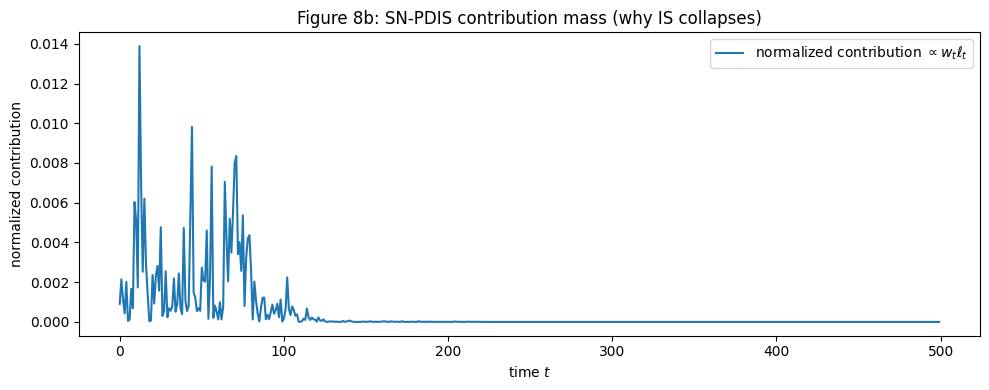

[saved] output1/fig_11_seed_boxplot.png


/var/folders/c1/wjgc3psx0gd_srfc6qkwvj1w0000gn/T/ipykernel_92063/2825508423.py:581: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([Jmb, Jsn, Jdr], labels=["MB", "SN-PDIS", "DR"])


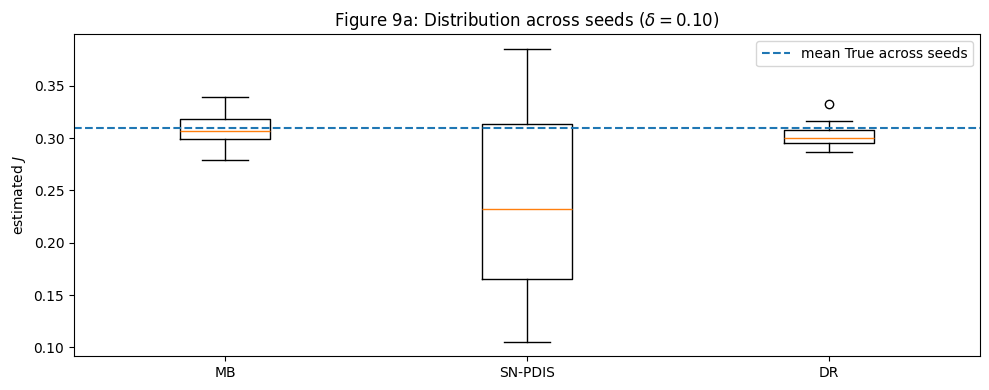

[saved] output1/fig_12_mse_barplot.png


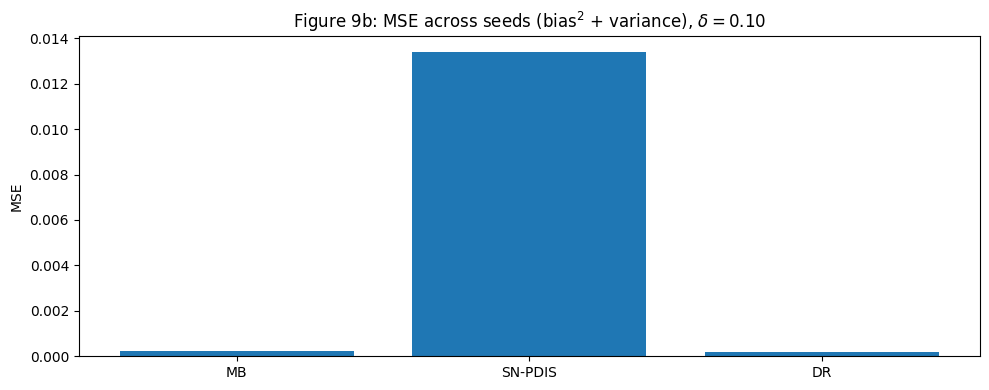


[Across-seed summary]
Mean True across seeds: 0.3100
Mean ESS across seeds : 17.62
MSE(MB)=2.4818e-04, MSE(SN)=1.3407e-02, MSE(DR)=2.0311e-04


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from numpy.linalg import inv
from scipy.linalg import cholesky, solve_discrete_are
import os

# ============================
# Output directory for figures
# ============================
OUTDIR = "output1"
os.makedirs(OUTDIR, exist_ok=True)

FIG_COUNTER = 1

def savefig(fig=None, name=None, dpi=200):
    """
    Save current figure (or given fig) into output1/ with automatic numbering.
    """
    global FIG_COUNTER
    if fig is None:
        fig = plt.gcf()
    if name is None:
        fname = f"fig_{FIG_COUNTER:02d}.png"
    else:
        fname = f"fig_{FIG_COUNTER:02d}_{name}.png"
    path = os.path.join(OUTDIR, fname)
    fig.savefig(path, dpi=dpi, bbox_inches="tight")
    print(f"[saved] {path}")
    FIG_COUNTER += 1

# ============================
# Helpers
# ============================
def sym(M): return 0.5*(M+M.T)

def psd_project(S, eps=1e-9):
    S = sym(S)
    w, V = np.linalg.eigh(S)
    w = np.clip(w, eps, None)
    return (V*w) @ V.T

def mvn_sample(cov):
    cov = psd_project(cov)
    L = cholesky(cov, lower=True)
    return L @ np.random.randn(cov.shape[0])

def spectral_radius(A):
    return float(np.max(np.abs(np.linalg.eigvals(A))))

def gaussian_logpdf(u, mean, cov):
    d = u.shape[0]
    Sinv = inv(cov)
    sign, logdet = np.linalg.slogdet(cov)
    e = u-mean
    return -0.5*(d*np.log(2*np.pi) + logdet + e.T@Sinv@e)

def ess_from_logweights(logw):
    lw = logw - np.max(logw)
    w = np.exp(lw)
    return float((w.sum()**2)/(np.sum(w*w)+1e-12))

# ============================
# Model
# ============================
@dataclass
class SSM:
    A: np.ndarray
    B: np.ndarray
    C: np.ndarray
    W: np.ndarray
    V: np.ndarray

# ============================
# Known stable system
# ============================
def make_known_stable_system(nx=4, nu=2, ny=2, seed=3) -> SSM:
    rng = np.random.default_rng(seed)

    def stable_block(r=0.90, theta=0.20):
        return r*np.array([[np.cos(theta), -np.sin(theta)],
                           [np.sin(theta),  np.cos(theta)]])

    A = np.block([
        [stable_block(0.92, 0.25), np.zeros((2,2))],
        [np.zeros((2,2)), stable_block(0.88, -0.18)]
    ])

    B = 0.2*rng.standard_normal((nx, nu))

    # C full row rank and well-conditioned
    C0 = rng.standard_normal((ny, nx))
    Q,_ = np.linalg.qr(C0.T)
    C = Q.T[:ny, :]  # ny x nx

    W = 0.02*np.eye(nx)
    V = 0.05*np.eye(ny)
    return SSM(A,B,C,W,V)

# ============================
# LQR -> output feedback mapping
# ============================
def lqr_gain(A,B,Q,R):
    P = solve_discrete_are(A,B,Q,R)
    Kx = -inv(R + B.T@P@B) @ (B.T@P@A)
    return Kx

def stabilize_Ky(A,B,C,Ky, rho_target=0.95, max_tries=200):
    Ky2 = Ky.copy()
    for _ in range(max_tries):
        if spectral_radius(A + B@Ky2@C) < rho_target:
            return Ky2
        Ky2 *= 0.9
    raise RuntimeError("Could not stabilize Ky (unexpected for this system).")

def make_output_feedback_policies(ssm:SSM, Qx, R, delta=0.10, rho_target=0.95, rng=None):
    if rng is None:
        rng = np.random.default_rng(0)
    A,B,C = ssm.A, ssm.B, ssm.C
    Kx = lqr_gain(A,B,Qx,R)
    Ky_base = Kx @ C.T @ inv(C@C.T)
    Ky_b = stabilize_Ky(A,B,C,Ky_base, rho_target=rho_target)
    Ky_e = stabilize_Ky(A,B,C,Ky_b + delta*rng.standard_normal(Ky_b.shape), rho_target=rho_target)
    return Ky_b, Ky_e

# ============================
# Simulation (observable cost)
# ============================
def simulate(ssm:SSM, Ky, Sigma_u, T=10000, burn=500, Qy=None, R=None):
    A,B,C,W,V = ssm.A,ssm.B,ssm.C,ssm.W,ssm.V
    nx=A.shape[0]; nu=B.shape[1]; ny=C.shape[0]
    if Qy is None: Qy=np.eye(ny)
    if R is None: R=0.1*np.eye(nu)

    x=np.zeros(nx)
    Y=np.zeros((T,ny))
    U=np.zeros((T,nu))
    cost=0.0; cnt=0

    for t in range(T):
        y = C@x + mvn_sample(V)
        u = Ky@y + mvn_sample(Sigma_u)
        x = A@x + B@u + mvn_sample(W)

        if not np.isfinite(x).all() or np.linalg.norm(x) > 1e8:
            raise RuntimeError("State blew up (should not happen with this construction).")

        Y[t]=y; U[t]=u
        if t>=burn:
            cost += float(y.T@Qy@y + u.T@R@u); cnt += 1

    return Y,U,cost/max(1,cnt)

# ============================
# Kalman + RTS smoother
# ============================
def kalman_rts(ssm:SSM, Y, U):
    A,B,C,W,V = ssm.A,ssm.B,ssm.C,ssm.W,ssm.V
    T=Y.shape[0]
    nx=A.shape[0]; ny=C.shape[0]

    x_pred=np.zeros((T+1,nx))
    P_pred=np.zeros((T+1,nx,nx))
    x_f=np.zeros((T+1,nx))
    P_f=np.zeros((T+1,nx,nx))
    innov=np.zeros((T,ny))
    S=np.zeros((T,ny,ny))

    x_f[0]=0.0
    P_f[0]=np.eye(nx)

    for t in range(T):
        x_pred[t+1]=A@x_f[t] + B@U[t]
        P_pred[t+1]=A@P_f[t]@A.T + W
        S_t=psd_project(C@P_pred[t+1]@C.T + V)
        K=P_pred[t+1]@C.T@inv(S_t)
        e=Y[t] - C@x_pred[t+1]
        x_f[t+1]=x_pred[t+1] + K@e
        P_f[t+1]=sym((np.eye(nx)-K@C)@P_pred[t+1])
        innov[t]=e; S[t]=S_t

    x_s=np.zeros_like(x_f); P_s=np.zeros_like(P_f); P_lag=np.zeros_like(P_f)
    x_s[-1]=x_f[-1]; P_s[-1]=P_f[-1]
    for t in reversed(range(T)):
        G=P_f[t]@A.T@inv(P_pred[t+1])
        x_s[t]=x_f[t] + G@(x_s[t+1]-x_pred[t+1])
        P_s[t]=sym(P_f[t] + G@(P_s[t+1]-P_pred[t+1])@G.T)
        P_lag[t+1]=sym(P_s[t+1]@G.T)

    return {"x_s":x_s,"P_s":P_s,"P_lag":P_lag,"x_pred":x_pred,"innov":innov,"S":S}

# ============================
# EM fitting on RAW (Y,U)
# ============================
def em_fit(Y,U,nx,iters=40,ridge=1e-3,rho_max=0.98, verbose=True):
    T,nu=U.shape; ny=Y.shape[1]

    A=0.7*np.eye(nx)
    B=0.05*np.random.randn(nx,nu)
    C=0.05*np.random.randn(ny,nx)
    W=0.1*np.eye(nx)
    V=0.1*np.eye(ny)

    curve=[]
    for k in range(iters):
        ssm=SSM(A,B,C,W,V)
        sm=kalman_rts(ssm,Y,U)
        xs,Ps,Plag = sm["x_s"], sm["P_s"], sm["P_lag"]

        curve.append(float(np.mean(np.sum(sm["innov"]**2,axis=1))))

        S_xx=np.zeros((nx,nx)); S_xu=np.zeros((nx,nu)); S_uu=np.zeros((nu,nu))
        S_xnext_x=np.zeros((nx,nx)); S_xnext_u=np.zeros((nx,nu))

        for t in range(T):
            Exx = Ps[t] + np.outer(xs[t],xs[t])
            S_xx += Exx
            S_xu += np.outer(xs[t],U[t])
            S_uu += np.outer(U[t],U[t])
            Exnext_x = Plag[t+1] + np.outer(xs[t+1],xs[t])
            S_xnext_x += Exnext_x
            S_xnext_u += np.outer(xs[t+1],U[t])

        G=np.block([[S_xx,S_xu],[S_xu.T,S_uu]]) + ridge*np.eye(nx+nu)
        RHS=np.hstack([S_xnext_x,S_xnext_u])
        AB=RHS @ inv(G)

        A=AB[:,:nx]
        r=spectral_radius(A)
        if r>=rho_max:
            A=A*(rho_max/(r+1e-12))
        B=AB[:,nx:]

        W_acc=np.zeros((nx,nx))
        for t in range(T):
            mu = xs[t+1] - A@xs[t] - B@U[t]
            cov = Ps[t+1] + A@Ps[t]@A.T - A@Plag[t+1].T - Plag[t+1]@A.T
            W_acc += np.outer(mu,mu) + cov
        W=psd_project(W_acc/T)

        XX=np.zeros((nx,nx)); YX=np.zeros((ny,nx))
        for t in range(T):
            Exx = Ps[t] + np.outer(xs[t],xs[t])
            XX += Exx
            YX += np.outer(Y[t], xs[t])
        C=YX @ inv(XX + ridge*np.eye(nx))

        V_acc=np.zeros((ny,ny))
        for t in range(T):
            mu = Y[t] - C@xs[t]
            V_acc += np.outer(mu,mu) + C@Ps[t]@C.T
        V=psd_project(V_acc/T)

        if verbose and ((k%5==0) or (k==iters-1)):
            print(f"[EM] iter {k:02d}: innov_energy={curve[-1]:.4f}, rho(A)={spectral_radius(A):.4f}")

    return SSM(A,B,C,W,V), np.array(curve)

# ============================
# OPE: SN-PDIS + DR
# ============================
def ope_sn_pdis(Y, U, Ky_b, Ky_e, Sigma_u, Qy, R, H=3000, clip=40.0):
    H = min(H, Y.shape[0])
    logw = 0.0
    logw_arr = np.zeros(H)
    l_arr = np.zeros(H)

    for t in range(H):
        mu_b = Ky_b @ Y[t]
        mu_e = Ky_e @ Y[t]
        logrho = gaussian_logpdf(U[t], mu_e, Sigma_u) - gaussian_logpdf(U[t], mu_b, Sigma_u)
        logrho = float(np.clip(logrho, -clip, clip))
        logw += logrho
        logw_arr[t] = np.clip(logw, -200, 200)

        l_arr[t] = float(Y[t].T @ Qy @ Y[t] + U[t].T @ R @ U[t])

    m = np.max(logw_arr)
    w = np.exp(logw_arr - m)
    J_sn = float(np.sum(w * l_arr) / (np.sum(w) + 1e-12))
    return J_sn, logw_arr, l_arr

def ope_dr_cv(Y, U, Ky_b, Ky_e, Sigma_u, Qy, R, H=3000, clip=40.0):
    H = min(H, Y.shape[0])

    logw = 0.0
    logw_arr = np.zeros(H)
    l_arr = np.zeros(H)
    lmb_arr = np.zeros(H)

    for t in range(H):
        mu_b = Ky_b @ Y[t]
        mu_e = Ky_e @ Y[t]
        logrho = gaussian_logpdf(U[t], mu_e, Sigma_u) - gaussian_logpdf(U[t], mu_b, Sigma_u)
        logrho = float(np.clip(logrho, -clip, clip))
        logw += logrho
        logw_arr[t] = np.clip(logw, -200, 200)

        l_arr[t] = float(Y[t].T @ Qy @ Y[t] + U[t].T @ R @ U[t])
        u_mb = mu_e
        lmb_arr[t] = float(Y[t].T @ Qy @ Y[t] + u_mb.T @ R @ u_mb)

    m = np.max(logw_arr)
    w = np.exp(logw_arr - m)

    J_mb_bar = float(np.mean(lmb_arr))
    J_dr = float(J_mb_bar + np.sum(w * (l_arr - lmb_arr)) / (np.sum(w) + 1e-12))
    return J_dr, logw_arr

# ============================
# One experiment runner (used for sweep and multi-seed)
# ============================
def run_one(delta, seed=0, T=10000, H=3000, em_iters=40, verbose_em=False):
    rng = np.random.default_rng(seed)

    nx,nu,ny = 4,2,2
    Qy=np.eye(ny)
    R=0.1*np.eye(nu)
    Sigma_u=(0.12**2)*np.eye(nu)
    Qx=np.eye(nx)

    ssm_true = make_known_stable_system(nx,nu,ny,seed=3)  # keep same plant across sweep

    Ky_b, Ky_e = make_output_feedback_policies(ssm_true, Qx, R, delta=delta, rho_target=0.95, rng=rng)

    # True
    _, _, J_true = simulate(ssm_true, Ky_e, Sigma_u, T=T, burn=500, Qy=Qy, R=R)

    # Logged
    Y_obs, U_obs, _ = simulate(ssm_true, Ky_b, Sigma_u, T=T, burn=500, Qy=Qy, R=R)

    # EM on raw
    ssm_hat, em_curve = em_fit(Y_obs, U_obs, nx, iters=em_iters, ridge=1e-3, rho_max=0.98, verbose=verbose_em)

    # MB
    _, _, J_mb = simulate(ssm_hat, Ky_e, Sigma_u, T=T, burn=500, Qy=Qy, R=R)

    # SN-PDIS + DR + ESS
    J_sn, logw_arr, l_arr = ope_sn_pdis(Y_obs, U_obs, Ky_b, Ky_e, Sigma_u, Qy, R, H=H, clip=40.0)
    J_dr, logw_dr = ope_dr_cv(Y_obs, U_obs, Ky_b, Ky_e, Sigma_u, Qy, R, H=H, clip=40.0)
    ess = ess_from_logweights(logw_arr)

    return {
        "delta": delta,
        "J_true": J_true,
        "J_mb": J_mb,
        "J_sn": J_sn,
        "J_dr": J_dr,
        "ess": ess,
        "logw": logw_arr,
        "l_arr": l_arr,
        "em_curve": em_curve,
        "Ky_b": Ky_b,
        "Ky_e": Ky_e,
        "rho_b": spectral_radius(ssm_true.A + ssm_true.B@Ky_b@ssm_true.C),
        "rho_e": spectral_radius(ssm_true.A + ssm_true.B@Ky_e@ssm_true.C),
        "Y_obs": Y_obs,
        "U_obs": U_obs,
        "ssm_hat": ssm_hat,
        "ssm_true": ssm_true,
    }

# ============================
# MAIN
# ============================
if __name__ == "__main__":
    import os
    import numpy as np
    import matplotlib.pyplot as plt

    # -------------------------
    # Helper: save all figures
    # -------------------------
    OUTDIR = "output1"
    os.makedirs(OUTDIR, exist_ok=True)

    def savefig(fig, name, dpi=200):
        path = os.path.join(OUTDIR, f"{name}.png")
        fig.savefig(path, dpi=dpi, bbox_inches="tight")
        print(f"[saved] {path}")

    # ============================
    # Base run (your current setting)
    # ============================
    base = run_one(delta=0.10, seed=0, T=10000, H=3000, em_iters=40, verbose_em=True)

    print("\n=== Base results ===")
    print("rho(A + B Ky_b C) =", base["rho_b"])
    print("rho(A + B Ky_e C) =", base["rho_e"])
    print(f"True J(pi_e)         : {base['J_true']:.4f}")
    print(f"MB (learned sim)     : {base['J_mb']:.4f}")
    print(f"SN-PDIS estimate     : {base['J_sn']:.4f}   (ESS≈{base['ess']:.1f})")
    print(f"DR (control variate) : {base['J_dr']:.4f}")

    # ============================
    # Pull common objects
    # ============================
    Tplot   = 600
    Y_obs   = base["Y_obs"]
    U_obs   = base["U_obs"]
    em_curve= base["em_curve"]
    ssm_hat = base["ssm_hat"]

    # ============================
    # Fig 1: Logged data
    # ============================
    fig, axs = plt.subplots(4, 1, figsize=(10, 7), sharex=True)
    fig.suptitle(r"Figure 1: Logged data under behavior $\pi_b$", fontsize=14)

    for i in range(2):
        axs[i].plot(Y_obs[:Tplot, i])
        axs[i].set_ylabel(f"$y_{{{i+1},t}}$")

    for i in range(2):
        axs[2+i].plot(U_obs[:Tplot, i])
        axs[2+i].set_ylabel(f"$u_{{{i+1},t}}$")

    axs[-1].set_xlabel("time $t$")
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    savefig(fig, "fig_01_logged_data")
    plt.show()

    # ============================
    # Fig 2: EM convergence
    # ============================
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(em_curve)
    ax.set_title("Figure 2: EM convergence (mean innovation energy)")
    ax.set_xlabel("EM iteration")
    ax.set_ylabel(r"mean $\|\mathrm{innov}\|^2$")
    fig.tight_layout()
    savefig(fig, "fig_02_em_convergence")
    plt.show()

    # ============================
    # Fig 3: One-step prediction fit
    # Fig 4: Innovations with ±2σ bands
    # ============================
    sm = kalman_rts(ssm_hat, Y_obs, U_obs)
    yhat  = (ssm_hat.C @ sm["x_pred"].T).T[:-1]     # y_{t|t-1}
    innov = sm["innov"]                              # e_t
    S     = sm["S"]                                  # innovation covariance
    j = 0

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(Y_obs[:Tplot, j], label="observed $y$")
    ax.plot(yhat[:Tplot, j], label=r"predicted $\hat y_{t|t-1}$")
    ax.set_title("Figure 3: One-step prediction fit (raw units)")
    ax.set_xlabel("time $t$")
    ax.legend()
    fig.tight_layout()
    savefig(fig, "fig_03_prediction_fit")
    plt.show()

    fig, ax = plt.subplots(figsize=(10, 4))
    sig = np.sqrt(np.maximum(1e-12, S[:Tplot, j, j]))
    ax.plot(innov[:Tplot, j], label=r"innovation $e_t$")
    ax.plot(2*sig, "--", label=r"$+2\sigma$")
    ax.plot(-2*sig, "--", label=r"$-2\sigma$")
    ax.set_title("Figure 4: Innovations with confidence bands (diagnostic)")
    ax.set_xlabel("time $t$")
    ax.legend()
    fig.tight_layout()
    savefig(fig, "fig_04_innovation_bands")
    plt.show()

    # ============================
    # Fig 5: Cumulative log-weights
    # ============================
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(base["logw"])
    ax.set_title(f"Figure 5: Cumulative log-weights (SN-PDIS), ESS≈{base['ess']:.1f}")
    ax.set_xlabel("time $t$")
    ax.set_ylabel(r"$\log w_t$")
    fig.tight_layout()
    savefig(fig, "fig_05_log_weights")
    plt.show()

    # ============================
    # Fig 6: OPE comparison (single run)
    # ============================
    fig, ax = plt.subplots(figsize=(9, 5))
    names = ["True(sim)", "MB(sim learned)", "SN-PDIS", "DR"]
    vals  = [base["J_true"], base["J_mb"], base["J_sn"], base["J_dr"]]
    ax.bar(names, vals)
    ax.axhline(base["J_true"], linestyle="--", label="True (this run)")
    ax.set_title(r"Figure 6: OPE estimates for $J(\pi_e)$ (single run)")
    ax.set_ylabel("average cost")
    ax.legend()
    fig.tight_layout()
    savefig(fig, "fig_06_ope_comparison")
    plt.show()

    # ============================
    # Fig 7a/7b: ESS and error vs policy shift δ
    # ============================
    deltas = [0.00, 0.02, 0.04, 0.06, 0.08, 0.10, 0.12]
    ess_list, err_sn, err_dr = [], [], []

    for d in deltas:
        out = run_one(delta=d, seed=0, T=8000, H=2000, em_iters=25, verbose_em=False)
        ess_list.append(out["ess"])
        err_sn.append(abs(out["J_sn"] - out["J_true"]))
        err_dr.append(abs(out["J_dr"] - out["J_true"]))

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(deltas, ess_list, marker="o")
    ax.set_title("Figure 7a: Effective Sample Size (ESS) vs policy shift $\\delta$")
    ax.set_xlabel("policy shift $\\delta$")
    ax.set_ylabel("ESS (SN-PDIS)")
    fig.tight_layout()
    savefig(fig, "fig_07_ess_vs_delta")
    plt.show()

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(deltas, err_sn, marker="o", label=r"$|\mathrm{SN\!-\!PDIS} - \mathrm{True}|$")
    ax.plot(deltas, err_dr, marker="o", label=r"$|\mathrm{DR} - \mathrm{True}|$")
    ax.set_title("Figure 7b: Estimator absolute error vs policy shift $\\delta$")
    ax.set_xlabel("policy shift $\\delta$")
    ax.set_ylabel("absolute error")
    ax.legend()
    fig.tight_layout()
    savefig(fig, "fig_08_error_vs_delta")
    plt.show()

    # ============================
    # Fig 8a/8b: Weight-mass intuition (first 500 steps)
    # ============================
    logw  = base["logw"]
    l_arr = base["l_arr"]

    m = float(np.max(logw))
    w = np.exp(logw - m)
    contrib = (w * l_arr) / (np.sum(w) + 1e-12)

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(l_arr[:500], label=r"instantaneous cost $\ell_t$")
    ax.set_title("Figure 8a: Instantaneous cost (first 500 steps of OPE window)")
    ax.set_xlabel("time $t$")
    ax.set_ylabel(r"$\ell_t$")
    ax.legend()
    fig.tight_layout()
    savefig(fig, "fig_09_instantaneous_cost")
    plt.show()

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(contrib[:500], label=r"normalized contribution $\propto w_t \ell_t$")
    ax.set_title("Figure 8b: SN-PDIS contribution mass (why IS collapses)")
    ax.set_xlabel("time $t$")
    ax.set_ylabel("normalized contribution")
    ax.legend()
    fig.tight_layout()
    savefig(fig, "fig_10_weighted_contribution")
    plt.show()

    # ============================
    # Fig 9a/9b: Across-seed distribution + MSE
    # IMPORTANT FIX: explicitly label the dashed line as "mean True across seeds"
    # ============================
    DO_FIG9 = True
    if DO_FIG9:
        seeds = list(range(10))
        Jt, Jmb, Jsn, Jdr, ESS = [], [], [], [], []
        for s in seeds:
            out = run_one(delta=0.10, seed=s, T=6000, H=2000, em_iters=25, verbose_em=False)
            Jt.append(out["J_true"])
            Jmb.append(out["J_mb"])
            Jsn.append(out["J_sn"])
            Jdr.append(out["J_dr"])
            ESS.append(out["ess"])

        Jt  = np.array(Jt)
        Jmb = np.array(Jmb)
        Jsn = np.array(Jsn)
        Jdr = np.array(Jdr)
        ESS = np.array(ESS)

        true_ref = float(np.mean(Jt))  # mean True across seeds

        fig, ax = plt.subplots(figsize=(10, 4))
        ax.boxplot([Jmb, Jsn, Jdr], labels=["MB", "SN-PDIS", "DR"])
        ax.axhline(true_ref, linestyle="--", label="mean True across seeds")
        ax.set_title(r"Figure 9a: Distribution across seeds ($\delta=0.10$)")
        ax.set_ylabel("estimated $J$")
        ax.legend()
        fig.tight_layout()
        savefig(fig, "fig_11_seed_boxplot")
        plt.show()

        mse_mb = float(np.mean((Jmb - true_ref)**2))
        mse_sn = float(np.mean((Jsn - true_ref)**2))
        mse_dr = float(np.mean((Jdr - true_ref)**2))

        fig, ax = plt.subplots(figsize=(10, 4))
        ax.bar(["MB", "SN-PDIS", "DR"], [mse_mb, mse_sn, mse_dr])
        ax.set_title(r"Figure 9b: MSE across seeds (bias$^2$ + variance), $\delta=0.10$")
        ax.set_ylabel("MSE")
        fig.tight_layout()
        savefig(fig, "fig_12_mse_barplot")
        plt.show()

        print("\n[Across-seed summary]")
        print(f"Mean True across seeds: {true_ref:.4f}")
        print(f"Mean ESS across seeds : {float(np.mean(ESS)):.2f}")
        print(f"MSE(MB)={mse_mb:.4e}, MSE(SN)={mse_sn:.4e}, MSE(DR)={mse_dr:.4e}")

